# 匯入所需套件

In [36]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import cv2

In [37]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [38]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
# import package
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Activation, Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D)
from tensorflow.keras.utils import plot_model

# import data

In [40]:
data_path = "./train"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])

In [41]:
img_size = 224

In [42]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 0)
        img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])

    return np.array(data_img).astype('float32')/255.

In [46]:
x_data = load_img(x_data_list)

100%|██████████| 2985/2985 [00:02<00:00, 1156.01it/s]


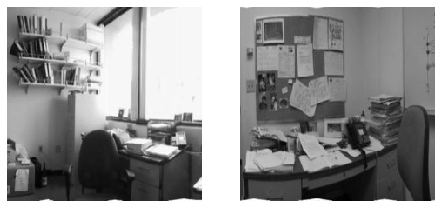

In [47]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_data[i][..., 0], cmap='gray')
    plt.axis('off')
plt.show()

In [48]:
y_data_list = pd.DataFrame(y_data_list, columns=['label'])
uniques = y_data_list['label'].value_counts().index
counts = y_data_list['label'].value_counts().values

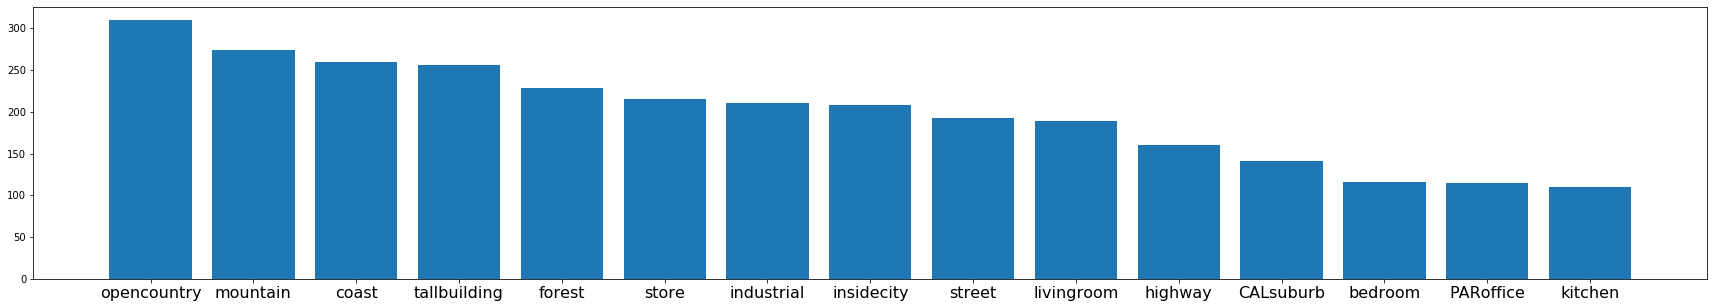

In [49]:
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [50]:
class_path = "./"
class_map = pd.read_csv(os.path.join(class_path, 'mapping.txt'),
                        header=None, index_col=0)
class_map = class_map.to_dict()[1]

y_data = y_data_list['label'].map(class_map).values.copy()

In [51]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.1,
                                                    random_state=86,
                                                    stratify=y_data)

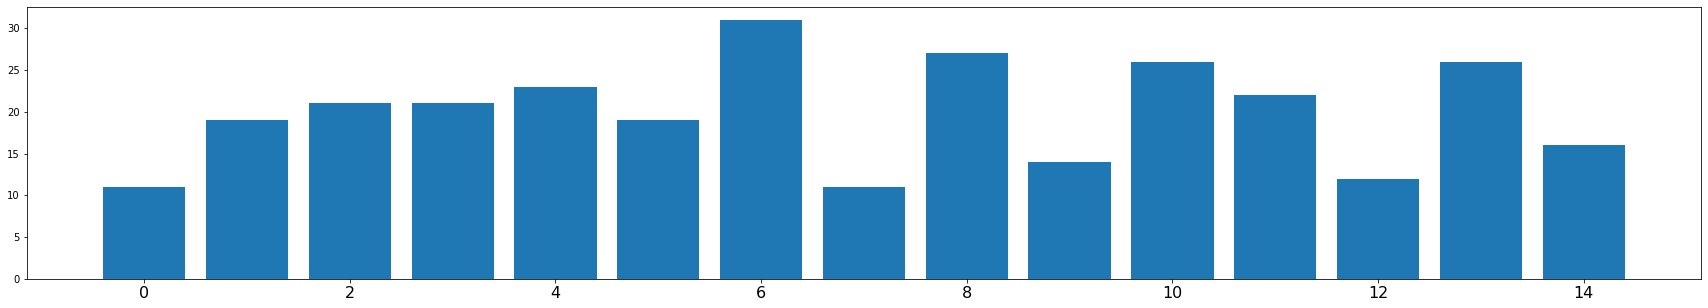

In [52]:
uniques, counts = np.unique(y_test, return_counts=True)

plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [53]:
num_classes = len(uniques)

y_train = np.eye(num_classes, dtype='float32')[y_train]
y_test = np.eye(num_classes, dtype='float32')[y_test]
print('y_train shape:', y_train.shape)

y_train shape: (2686, 15)


In [60]:
x_train.shape[1:]

(224, 224, 1)

In [54]:
# 用 model_2 試看看 data augmentation 的威力吧!!!

inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model_2 = Model(inputs=inputs, outputs=outputs)

In [55]:
learning_rate = 0.001
optimizer = keras.optimizers.Adam(lr=learning_rate)
batch_size = 32
epochs = 20

In [56]:
# initiate optimizer
model_2.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

In [57]:
model_dir = './Model/model_2-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model_2.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [58]:
num_step = x_train.shape[0] // batch_size

In [59]:
datagen = ImageDataGenerator(
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False,
                             fill_mode='nearest',
                             cval=0,
                             )


history_2 = model_2.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  steps_per_epoch=num_step,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks=callbacks_list
                                 )

Epoch 1/20
83/83 [==============================] - 35s 425ms/step - loss: 2.5795 - accuracy: 0.1827 - val_loss: 2.1678 - val_accuracy: 0.2609
Epoch 2/20
83/83 [==============================] - 34s 409ms/step - loss: 2.0097 - accuracy: 0.3274 - val_loss: 1.7032 - val_accuracy: 0.4582
Epoch 3/20
83/83 [==============================] - 34s 410ms/step - loss: 1.6177 - accuracy: 0.4533 - val_loss: 1.4094 - val_accuracy: 0.5050
Epoch 4/20
83/83 [==============================] - 33s 396ms/step - loss: 1.3901 - accuracy: 0.5222 - val_loss: 1.2530 - val_accuracy: 0.5318
Epoch 5/20
83/83 [==============================] - 32s 390ms/step - loss: 1.2449 - accuracy: 0.5799 - val_loss: 1.2641 - val_accuracy: 0.6054
Epoch 6/20
83/83 [==============================] - 20s 241ms/step - loss: 1.1096 - accuracy: 0.6153 - val_loss: 1.2030 - val_accuracy: 0.5753
Epoch 7/20
31/83 [==========>...................] - ETA: 6s - loss: 1.0442 - accuracy: 0.6492

KeyboardInterrupt: 

In [22]:
model = load_model('./Model/model_2-logs/basic_model-best-model.h5')
loss, acc = model.evaluate(x_test, y_test, verbose=2)

299/1 - 0s - loss: 0.9904 - accuracy: 0.7191


In [23]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(-1)

In [24]:
class_names = np.array([each for each in class_map.keys()])

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test.argmax(-1), y_pred))
print(confusion_matrix(y_test.argmax(-1), y_pred))

0.7190635451505016
[[ 2  0  0  2  0  3  0  3  0  0  0  0  0  1  0]
 [ 0 14  0  0  1  0  0  0  0  0  0  4  0  0  0]
 [ 0  1 12  4  0  0  0  0  0  1  0  3  0  0  0]
 [ 0  1  0 17  0  0  0  0  0  0  0  2  0  0  1]
 [ 0  0  0  0 23  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0 12  0  0  0  1  0  1  4  0  0]
 [ 0  0  0  0  5  0 22  0  2  0  2  0  0  0  0]
 [ 0  0  0  0  0  2  0  6  0  0  0  1  2  0  0]
 [ 0  0  0  0  5  0  4  0 17  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 13  0  1  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0 21  0  0  0  1]
 [ 0  0  0  1  1  0  0  1  0  0  0 19  0  0  0]
 [ 1  0  1  0  1  2  0  1  0  0  0  2  4  0  0]
 [ 0  0  1  0  0  1  0  0  1  0  0  1  0 22  0]
 [ 0  0  0  1  0  0  1  0  1  0  2  0  0  0 11]]


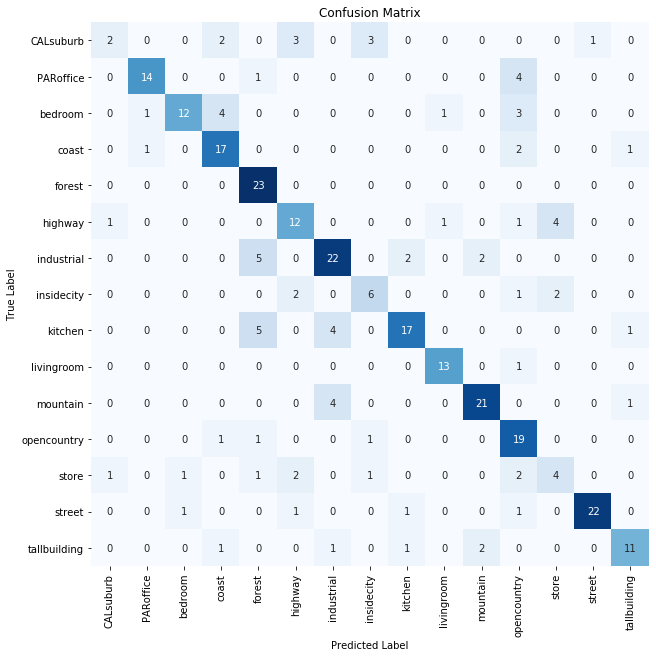

In [26]:
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(-1), y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

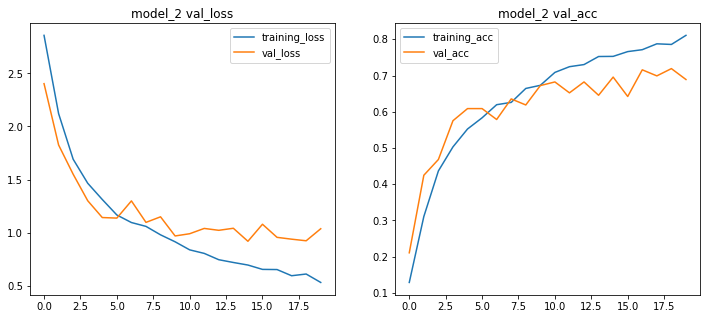

In [27]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history_2.history[eachx])
    plt.plot(np.arange(l_x), history_2.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model_2 ' + eachy)
plt.show()

In [63]:
test_path = "./testset"

X_data_list = []
Y_data_list = []
for roots, dirs, files in os.walk(test_path):
    for each in files:
        if each.find('checkpoint') == -1:
            X_data_list.append(os.path.join(roots, each))
            Y_data_list.append(each[:-4])

In [65]:
X_data = load_img(X_data_list)

100%|██████████| 1500/1500 [00:07<00:00, 187.87it/s]


In [66]:
X_data.shape

(1500, 224, 224, 1)

In [67]:
import numpy as np
import pandas as pd
pre = model.predict(X_data)
Y_label = np.argmax(pre, axis=1)

ans_df=pd.DataFrame()
ans_df['id']=Y_data_list
ans_df['class']=Y_label
ans_df.to_csv("answer.csv",index=False)

# Build the model

In [16]:
def call_list_fun(models, model_name):
    model_dir = './Model/{}-logs'.format(model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    logfiles = model_dir + '/{}-{}'.format('basic_model',
                                           models.__class__.__name__)
    model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                            histogram_freq=1)

    modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
    model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                                 monitor='val_accuracy',
                                                 save_best_only=True)

    earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=2)
    return [model_cbk, model_mckp, earlystop]

In [17]:
batch_size = 32
epochs = 20

# Add BatchNormalization

In [18]:
# 用 model_3 試看看 BatchNormalization 的威力吧!!!

inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model_3 = Model(inputs=inputs, outputs=outputs)

In [19]:
optimizer_3 = keras.optimizers.Adam(lr=1e-5)

In [20]:
model_3.compile(loss='categorical_crossentropy',
                optimizer=optimizer_3,
                metrics=['accuracy'])

In [21]:
callbacks_list_3 = call_list_fun(model_3, 'model_3')

# 如何使模型在一開始收斂時，有較穩定的收斂，來個 initializer 試看看

In [22]:
from tensorflow.keras import initializers

initial = initializers.he_normal()

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`


In [23]:
inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model_4 = Model(inputs=inputs, outputs=outputs)

In [24]:
callbacks_list_4 = call_list_fun(model_4, 'model_4')

In [25]:
optimizer_4 = keras.optimizers.Adam(lr=1e-6)
model_4.compile(loss='categorical_crossentropy',
                optimizer=optimizer_4,
                metrics=['accuracy'])

# 如果換掉了 Flatten 該....

In [26]:
from tensorflow.keras import initializers

initial = initializers.he_normal()
from tensorflow.keras.layers import GlobalAveragePooling2D

In [27]:
inputs = Input(shape=x_train.shape[1:])

x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initial)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.25)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model_5 = Model(inputs=inputs, outputs=outputs)

In [28]:
model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_8 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 32)      0         
__________

In [29]:
callbacks_list_5 = call_list_fun(model_5, 'model_5')

In [30]:
optimizer_5 = keras.optimizers.Adam(lr=1e-4)
model_5.compile(loss='categorical_crossentropy',
                optimizer=optimizer_5,
                metrics=['accuracy'])

# 訓練模型

In [31]:
num_step = x_train.shape[0] // batch_size + 1

In [32]:
datagen = ImageDataGenerator(
                             rescale = 1./255,
                             rotation_range = 10,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=False,
                             fill_mode='wrap',
                             cval=0,
                             )

In [33]:
# history_3 = model_3.fit_generator(datagen.flow(x_train, y_train,
#                                                batch_size=batch_size),
#                                   steps_per_epoch=num_step,
#                                   epochs=epochs,
#                                   validation_data=(x_test, y_test),
#                                   callbacks=callbacks_list_3)
# print('='*50)

# history_4 = model_4.fit_generator(datagen.flow(x_train, y_train,
#                                                batch_size=batch_size),
#                                   steps_per_epoch=num_step,
#                                   epochs=epochs,
#                                   validation_data=(x_test, y_test),
#                                   callbacks=callbacks_list_4)

print('='*50)
history_5 = model_5.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  steps_per_epoch=num_step,
                                  epochs=epochs,
                                  validation_data=(x_test, y_test),
                                  callbacks=callbacks_list_5)

Epoch 1/20
84/84 [==============================] - 88s 1s/step - loss: 2.5816 - acc: 0.1575 - val_loss: 2.6731 - val_acc: 0.1007
Epoch 2/20
84/84 [==============================] - 83s 985ms/step - loss: 2.4087 - acc: 0.2220 - val_loss: 2.7141 - val_acc: 0.1040
Epoch 3/20
84/84 [==============================] - 84s 996ms/step - loss: 2.2507 - acc: 0.2694 - val_loss: 2.8929 - val_acc: 0.1309
Epoch 4/20
84/84 [==============================] - 82s 980ms/step - loss: 2.0876 - acc: 0.3124 - val_loss: 2.9079 - val_acc: 0.1443
Epoch 5/20
84/84 [==============================] - 83s 990ms/step - loss: 1.9747 - acc: 0.3572 - val_loss: 2.8885 - val_acc: 0.1879
Epoch 6/20
84/84 [==============================] - 84s 998ms/step - loss: 1.8877 - acc: 0.3654 - val_loss: 2.1935 - val_acc: 0.2383
Epoch 7/20
84/84 [==============================] - 85s 1s/step - loss: 1.8080 - acc: 0.4053 - val_loss: 2.0811 - val_acc: 0.2819
Epoch 8/20
84/84 [==============================] - 84s 998ms/step - loss: 

# 訓練結果視覺化

In [51]:
model5_pred = model_5.evaluate(x_test, y_test, verbose=2)
print(model5_pred)

[1.5789312572287233, 0.43624161083826285]


In [52]:
y_pred = model_5.predict(x_test)
y_pred = y_pred.argmax(-1)

In [53]:
class_names = np.array([each for each in class_map.keys()])

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test.argmax(-1), y_pred))
print(confusion_matrix(y_test.argmax(-1), y_pred))

0.436241610738255
[[ 0  1  0  2  0  1  0  0  0  0  0  3  0  4  0]
 [ 0 10  1  0  4  0  2  0  1  0  0  0  0  1  0]
 [ 0  4  4  1  1  0  3  0  2  0  0  0  0  6  0]
 [ 0  1  0 11  3  0  1  0  0  0  0  0  0  5  0]
 [ 0  0  0  0 20  0  1  0  2  0  0  0  0  0  0]
 [ 0  3  7  0  0  2  0  0  0  2  0  3  0  2  0]
 [ 0  0  0  0  3  0 26  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  0  6  0  1  0  1  1  1  0  0  0]
 [ 0  0  0  0  6  0  9  0 12  0  0  0  0  0  0]
 [ 0  1  1  0  5  0  1  0  3  2  0  1  0  0  0]
 [ 0  0  0  0  0  0 10  0  2  0 11  0  0  0  3]
 [ 0  3  1  3  3  0  0  0  1  0  0  7  0  3  0]
 [ 0  2  2  0  0  3  1  1  1  0  0  0  1  1  0]
 [ 0  3  2  1  2  0  2  0  1  0  0  0  1 14  0]
 [ 0  0  0  0  1  0  4  0  0  0  2  0  0  0  9]]


Text(0.5,1,'Confusion Matrix')

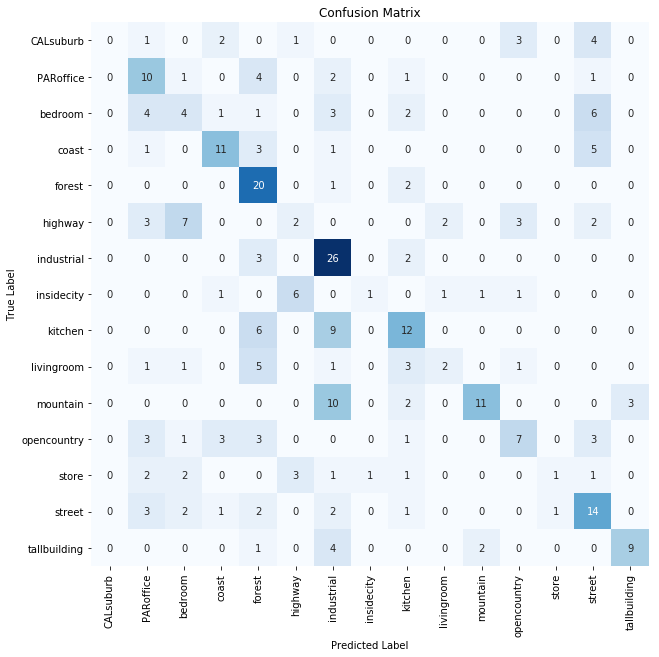

In [55]:
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(-1), y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [56]:
history_list = [history_5]
history_name = ["model_5_history"]

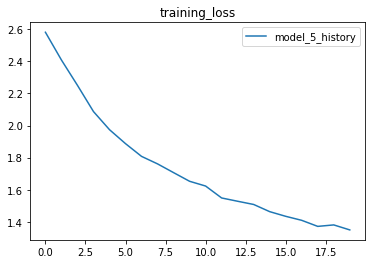

KeyError: 'accuracy'

In [57]:
# training loss
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['loss'])
    plt.plot(np.arange(l_x), each_his.history['loss'], label=each_name)
plt.legend(loc='best')
plt.title('training_loss')
plt.show()

# training acc
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['accuracy'])
    plt.plot(np.arange(l_x), each_his.history['accuracy'], label=each_name)
plt.legend(loc='best')
plt.title('training_acc')
plt.show()

# valid loss
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['val_loss'])
    plt.plot(np.arange(l_x), each_his.history['val_loss'], label=each_name)
plt.legend(loc='best')
plt.title('val_loss')
plt.show()


# valid acc
for each_his, each_name in zip(history_list, history_name):
    l_x = len(each_his.history['val_accuracy'])
    plt.plot(np.arange(l_x), each_his.history['val_accuracy'], label=each_name)
plt.legend(loc='best')
plt.title('val_acc')
plt.show()